# Predicting Insurance Costs

## Introduction

In these project we'll be working on [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle which contain information about individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it. 

We will use linear regression to predict total medical costs based on the impact of relationships with other demographic characteristics. Predicting medical costs is important because it allows hospitals to forecast revenues and plan for the necessary procedures required by the patient population.

In [1]:
# Importing all neccesary libraries
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

## Exploring Data

In [2]:
# Load in the insurance dataset
insurance = pd.read_csv('insurance.csv')

In [3]:
# Looking at the dataset
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# Columns in the dataset
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

| column name | description |
| ----------- | ----------- |
| age | age of primary beneficiary |
| sex | insurance contractor gender: female, male |
| bmi | Body mass index: providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9 |
| children | Number of children covered by health insurance / Number of dependents |
| smoker | Smoking |
| region | the beneficiary's residential area in the US: northeast, southeast, southwest, northwest |
| charges | Individual medical costs billed by health insurance |

In [5]:
# Information about dataset
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Our dataset contains  1338 rows (observations) and 7 columns (variables/features). In ouer dataset we have both categorical (dtype: **object**) and numerical (dtype: **int64**, **float**) variables. Categorical variables in the dataset are: 'sex', 'smoker' and 'region'. Also we don't have any missing values.

The `charges` column is our outcome, while everything else are the potential predictors to use in the model. Let's check what the distribution of our outcome looks like.

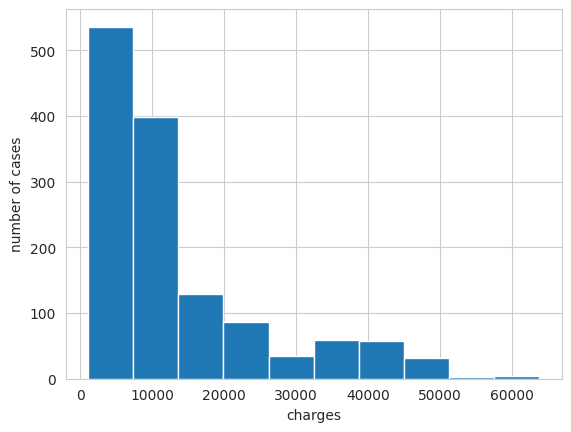

In [6]:
# Creating histogram for `charges` column
insurance['charges'].hist()
plt.xlabel('charges')
plt.ylabel('number of cases')
plt.show()

As we can see on the histogram distribution of `charges` column is highly right-skewed. It means that in our data we have more low cost insurances and these is unusual situation because extremely costly insurance charges are more common than extremely small ones. This makes it unlikely that the errors in the model are actually centered at zero. So it's worth converting the result to a logarithm to get a distribution close to normal.

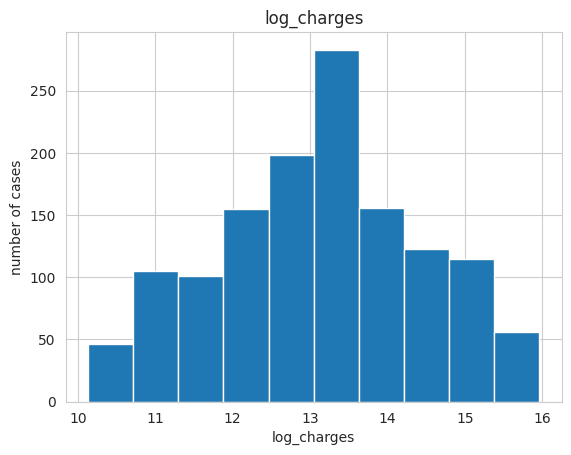

In [7]:
# Creating logarithm column for `charges`
insurance["log_charges"] = np.log2(insurance["charges"])

# Plot the histogram of the log transformed outcome
insurance.hist("log_charges")
plt.xlabel('log_charges')
plt.ylabel('number of cases')
plt.show()

The log-transformed charges values are more centered, which is what we wanted. This makes it more likely that the errors will be unbiased.

Now we'll check corelation between predictor variables and the outcome.

In [8]:
# Calculation the correlation
corr_matrix = insurance.corr()
corr_matrix

,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


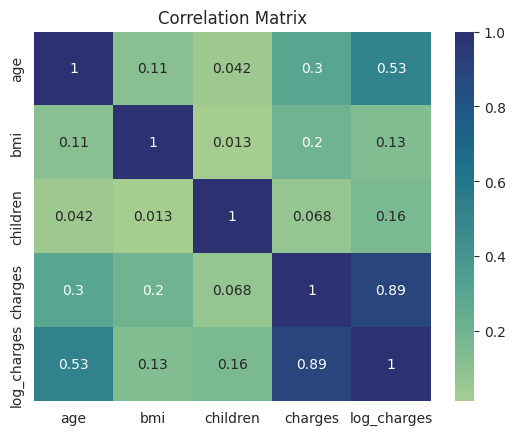

In [9]:
# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap="crest")
plt.title('Correlation Matrix')
plt.show()

On abowe heatmap `age` has ~30% correlation with `charges`, `bmi` has ~20% correlation and number od children has ~7% corelation.

Now we'll create box plots for categorical variables to see correlation with `log_charges'

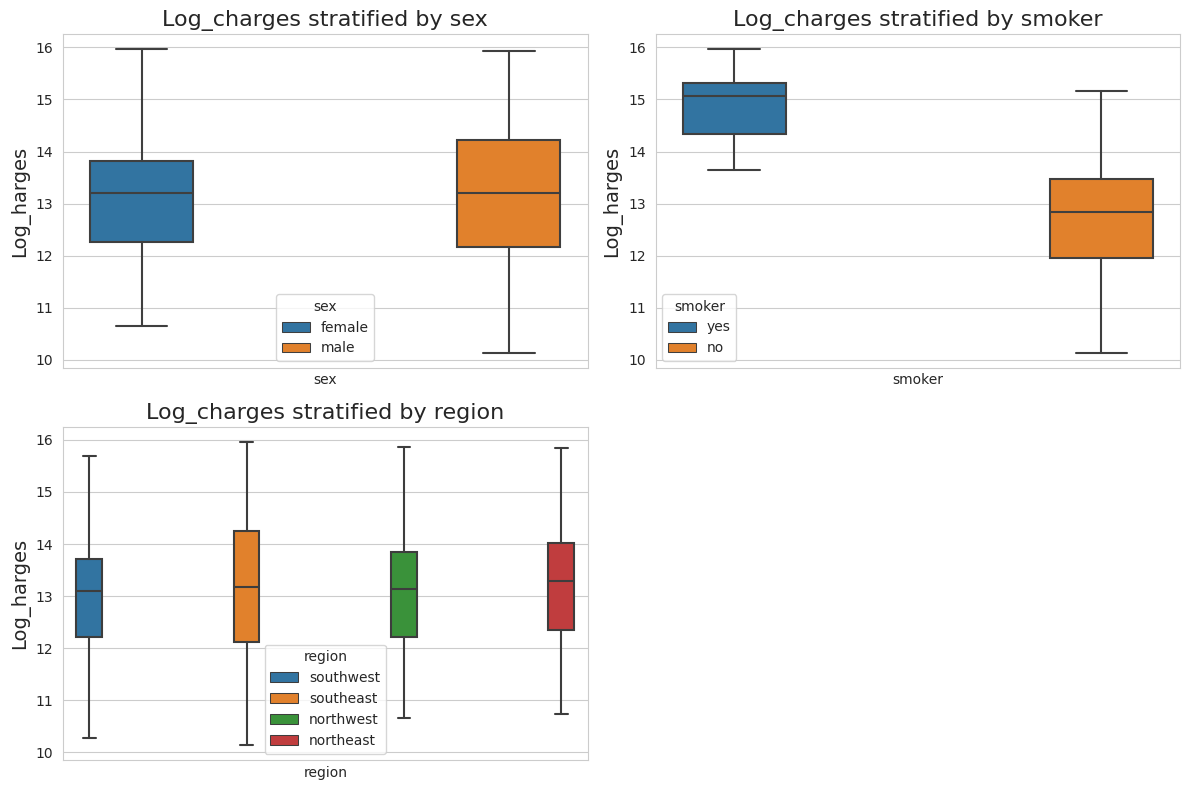

In [10]:
# Box plots for categorical columns

plt.figure(figsize=(12,8))

for i, col in enumerate(['sex', 'smoker', 'region']):
    ax = plt.subplot(2,2, i+1)
    sns.boxplot(data=insurance, x=col, y='log_charges', hue=col)
    ax.set_title('Log_charges stratified by {}'.format(col), fontsize = 16)
    ax.set_ylabel('Log_harges', fontsize = 14)
    ax.set_xticks([])
    
plt.tight_layout()
plt.show()

Looking at box plot we can tell that:
- males seem to have a wider distribution of charges compared to women,
- smokers have much higher costs than non-smokers,
- there doesn't seem to be many appreciable differences between regions.

Based on the relationships shown above, in our model we iclue: `age`, `bmi` and `smoker` as predictors because thse parameters are positively associated with higher `charges`.

## Dividing The Data

Now that we find our predictors we can start build our model. But before we do that we need to divide dataset in to two portions:
- training set that will be used to estimate the regression coefficients,
- and test set that will be used to assess the predictive ability of the model.

Because smokers tend to have higher cost as compared to non smokers we will create new column which contain information True or False depending on beeing a smoker.

In [11]:
# Creating new column with contain information about beeing a smoker
insurance["is_smoker"] = (insurance["smoker"] == "yes")
insurance.head()

,age,sex,bmi,children,smoker,region,charges,log_charges,is_smoker
0,19,female,27.900,0,yes,southwest,16884.92400,14.043448,True
1,18,male,33.770,1,no,southeast,1725.55230,10.752842,False
2,28,male,33.000,3,no,southeast,4449.46200,12.119415,False
3,33,male,22.705,0,no,northwest,21984.47061,14.424197,False
4,32,male,28.880,0,no,northwest,3866.85520,11.916945,False


Now lest divide our data.

In [12]:
# Splitting the data up into a training and test set
X = insurance[['age', 'bmi', 'is_smoker']]
y = insurance['log_charges']

# 70% for training set, 30% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=450)

## Model Building

Now we're ready to build our predictive linear model. After model bilding wew can try find answers for below questions:
- Do the coefficient values make sense considering their correlation with the outcome?
- What does the coefficient of determination suggest about the model fit?
- How well does the model predict the medical costs in the training set?

The columns in X_train dataset have different ranges. For example `is_smoker` column has takes boolean values: `True` (1) or `Fasle` (0). Whereas `bmi` and `age` columns can take values in a bigger range.

Therefore we'll can build the model in two ways:
- without feature scaling (the algorithm naturally handles features with different scales),
- with feature scaling.

We'll going to bulid model without feature scaling.

### Linear Regression Without Feature Scaling

In [13]:
# Build the model
insurance_model = LinearRegression()

# Fitting the model on training set
insurance_model.fit(X_train, y_train)

LinearRegression()

#### Metrics of model

In [14]:
# Get predicted values by model
predictions = insurance_model.predict(X_train)

# Coefficient of determination
R2 = r2_score(y_train, predictions)
R2

0.752096729148337

In [15]:
# MSE on the log scale for the insurance charges
mean_squared_error(y_train, predictions)

0.443222523021715

In [16]:
# MSE on the original scale for the insurance charges
np.exp(mean_squared_error(y_train, predictions))

1.5577189241002225

In [17]:
# RMSE on the log scale for the insurance charges
mean_squared_error(y_train, predictions, squared=False)

0.6657495948340599

In [18]:
np.exp(mean_squared_error(y_train, predictions, squared=False))

1.9459486478202674

Having coefficient of determination above 0.75 is a good indication. Meaning that more than 75% of the varation in the target column is being caused by the features we're examining.
The MSE 0.44 and 1.56 on orginal sacleand RMSE 0.67 and 1.95 on orginal scale also look promising, but we must remember that these are optimistic values.

#### Residual Diagnostics

We have trained and fitted our model. However, before we continue further we should examine how well our linear model is complying with the assumptions.

In [19]:
# Compute the residuals
residuals = y_train - predictions

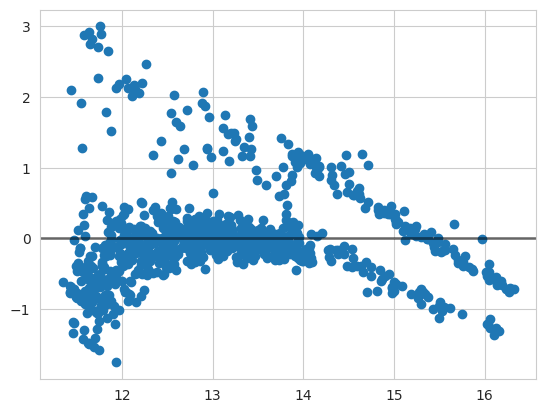

In [20]:
# Plot a scatter to examine the variance of the residual
plt.scatter(predictions, residuals)
plt.axhline( y = 0, 
           color = 'black',
           linewidth = 2, alpha=0.5)
plt.show()

Residuals suggest some violations of linear regression assumptions. As fitted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.

#### Interpreting The Model

In [21]:
# Examine the coefficients
insurance_model.coef_

array([0.05121227, 0.0159098 , 2.27895348])

The coefficient associated with a predictor should be interpreted as the change in the average score for a unit change in the predictor. For categorical variables, a unit change means a change in the category of the categorical variable.

Accordingly, the coefficient of the `is_smoker` column is high, as expected, because there is a large difference between the charges for non-smokers and smokers, as examined above using box plots.
Moreover, the fact that the `bmi` column has a higher coefficient than the `age` column is parallel to the fact that the age column has a higher correlation with the `log_charges` column. As such, we would expect a unit increase in the `age` predictor to have a greater impact than a unit increase in the `bmi` predictor.

In [22]:
# Examine the intercept
insurance_model.intercept_

10.173769457029366

Looking at the intercept of this model we can infer that the intercept shows a positive intercept. For `age` and `bmi` column it can be interpreted directly because there are no age and bmi equal 0, so there's no meaning here. For `is_smoker` column situation is different. Since these column is categorical it can take only values 0 (non-smoker) or 1 (smoker). The value for the intercept term here means the average number of `log_charge` is 10.17 when patient is non-smoker.

## Final Model Evaluation

In [23]:
# Get test predicted values by model
test_predictions = insurance_model.predict(X_test)

In [24]:
# Coefficient of determination
R2 = r2_score(y_test, test_predictions)
R2

0.7249820876576745

In [25]:
# MSE on the log scale for the insurance charges
mean_squared_error(y_test, test_predictions)

0.46472271623467754

In [26]:
# MSE on the original scale for the insurance charges
np.exp(mean_squared_error(y_test, test_predictions))

1.5915728103947329

In [27]:
# RMSE on the log scale for the insurance charges
mean_squared_error(y_test, test_predictions, squared=False)

0.6817057402095699

In [28]:
# RMSE on the original scale for the insurance charges
np.exp(mean_squared_error(y_test, test_predictions, squared=False))

1.9772475280281336

The test MSE was about 0.464, while the training MSE was about 0.443. In this case, the small discrepancy between the two errors indicates that we can conclude that the model is not over-fitting. 

## Conclusions

The test MSE value compared to train MSE value sugest that our model is not overfitting and it predicts unseen data well. On the other hand the residual values suggest that the model predicts much lower costs for people who have actually been charged much more.  Consequently, the model encounters difficulty when dealing with these elevated costs. To sum it up, the model's overall predictions lean towards being overly cautious or conservative.